In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#from keras.utils import np_utils
#from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = '../'
# all parameters not specified are set to their defaults

In [3]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for seismic_type in os.listdir(folder):
        if not seismic_type.startswith('.'):
            if seismic_type in ['Class1']:
                label = '0'
            else:
                label = '1'
            for image_filename in os.listdir(folder + seismic_type):
                img_file = cv2.imread(folder + seismic_type + '/' + image_filename, 0)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    # img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [4]:
X_train, y_train = get_data(BASE_DIR + 'images/Train/')
X_test, y_test = get_data(BASE_DIR + 'images/Test/')

#scikit-learn expects 2d num arrays for the training dataset for a fit function. 
#The dataset you are passing in is a 3d array you need to reshape the array into a 2d.

nsamples, nx, ny = X_train.shape
nsamples2, nx2, ny2 = X_test.shape
X_train_new = X_train.reshape((nsamples,nx*ny))
X_test = X_test.reshape((nsamples2,nx2*ny2))

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [5]:
#############################################################################
# Compute a PCA (anticlines) on the anticlines dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
from time import time
n_components = 50

print("Extracting the top %d eigen-anticlines from %d anticlines"
      % (n_components, X_train_new.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_new)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the eigen-anticlines orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train_new)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 50 eigen-anticlines from 400 anticlines
done in 1.530s
Projecting the input data on the eigen-anticlines orthonormal basis
done in 0.397s


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from time import time
from sklearn import svm
# #############################################################################
# Train a SVM classification model

#print("Fitting the classifier to the training set")
#t0 = time()
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
#clf = clf.fit(X_train_new, y_train)
#print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

#print("Predicting anticlines on the test set")
#t0 = time()
#y_pred = clf.predict(X_test)
#print("done in %0.3fs" % (time() - t0))

clf = svm.SVC(kernel='linear', C = 100.0)
#clf = svm.SVC(kernel='rbf', gamma=0.1, C = 100.0)
clf.fit(X_train_pca,y_train)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.93      1.00      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[23  2]
 [ 0 25]]


In [7]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)

0.96


In [8]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[23  2]
 [ 0 25]]


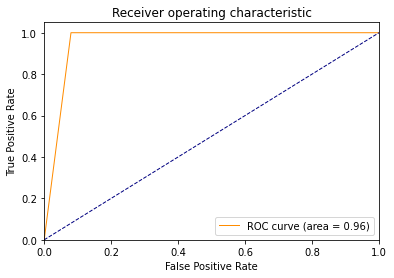

In [9]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

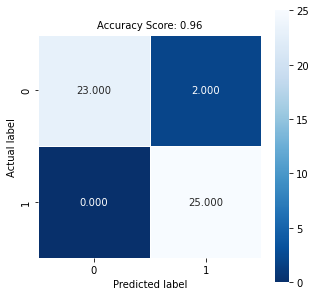

In [10]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 10);